In [1]:
import pygmt
import numpy as np
import pandas as pd
import re
import json
import matplotlib.pyplot as plt

In [2]:
def australia():
    ln_min, ln_max = (112, 155)
    lt_min, lt_max = (-46, -8)
    region = [ln_min, ln_max, lt_min, lt_max]
    projection = f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/15c"
    fig = pygmt.Figure()
    fig.basemap(region=region, projection=projection, frame=True)
    fig.coast(
        region=region,
        projection=projection,
        shorelines=1,
        resolution="i",
        borders="2/1p,grey",
        land="#ffffe6",
        water="#e6ffff",
    )
    return fig, region, projection


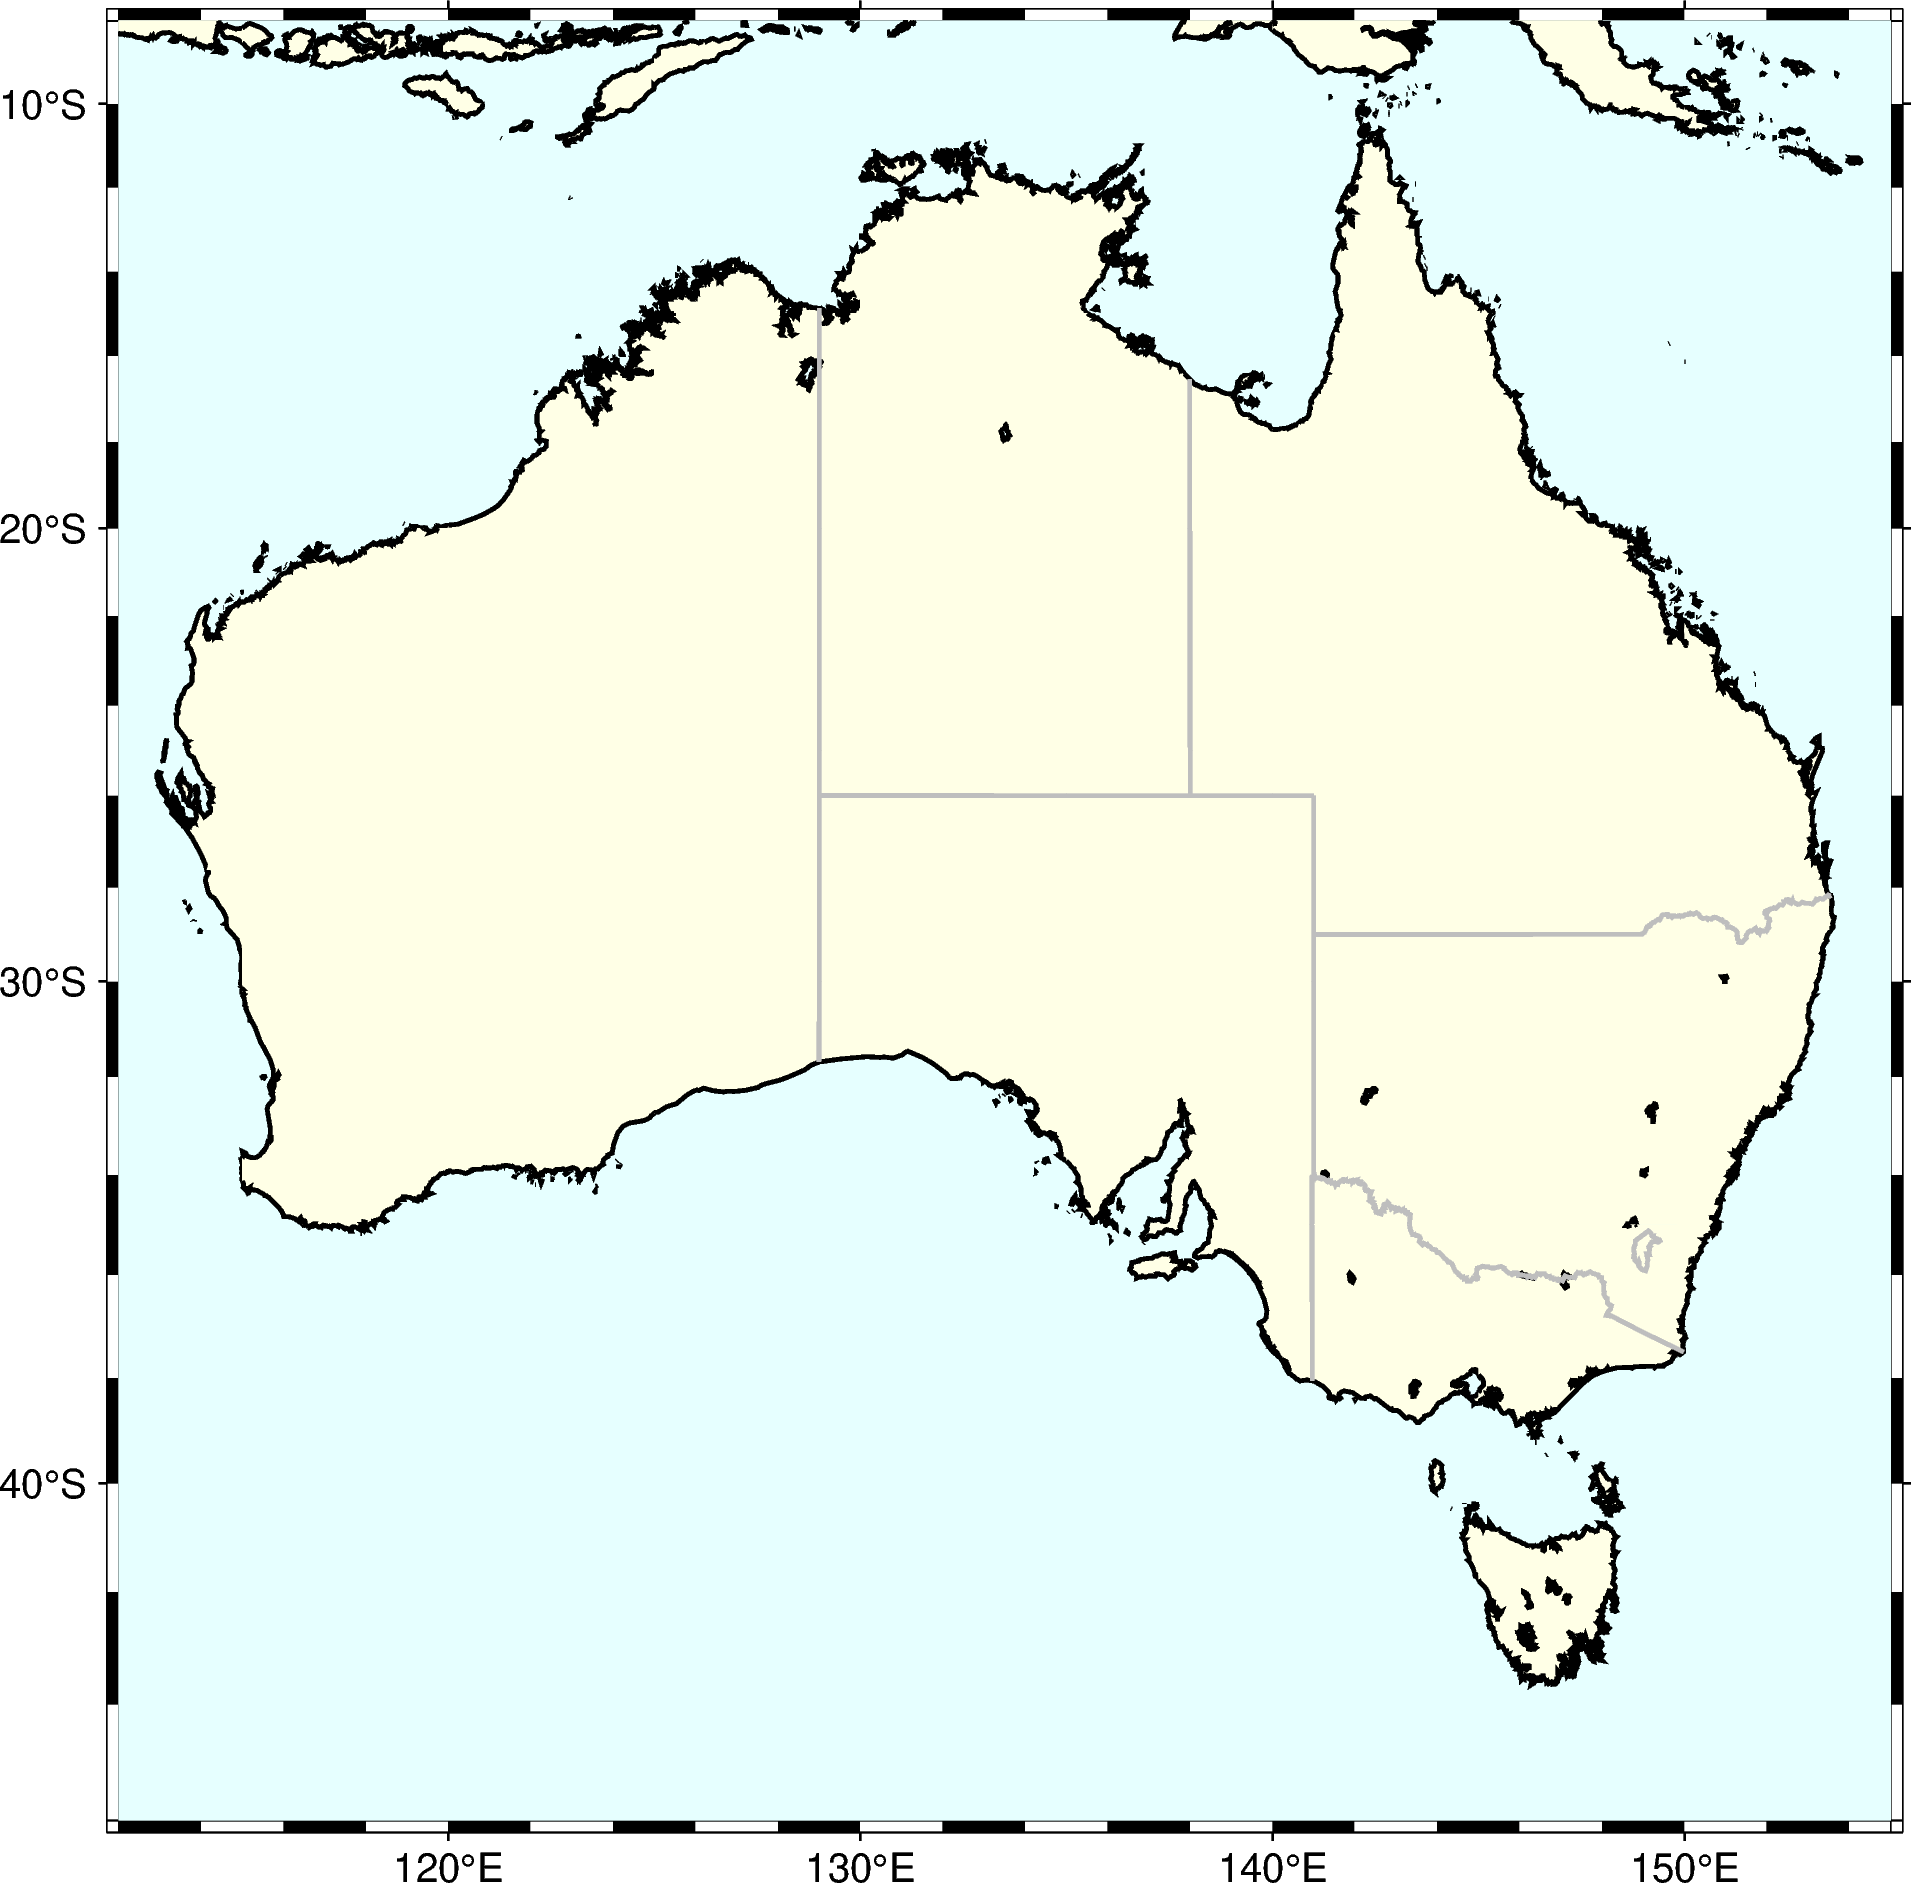

In [3]:
fig, region, projection = australia()
fig.show()

In [4]:
with open(
    "/Users/auggiemarignier/data/interactive-geological-timescale/src/assets/timeline_data.json",
    "r",
) as read_file:
    main = json.load(read_file)
    geological_timeline = {m["name"]: m for m in main}

with open("/Users/auggiemarignier/data/interactive-geological-timescale/src/assets/time_interval_data.json", "r") as read_file:
    intervals = json.load(read_file)
    
for K, V in geological_timeline.items():
    for k, v in intervals.items():
        if k.split("/")[-1] == K:
            V |= v
            break
for K, V in geological_timeline.items():
    del V["name"]
    for k, v in V.items():
        if k == "narrow":
            V["children"] = [n.split("/")[-1] for n in v]
            del V[k]
        elif k == "broad":
            V["parent"] = [b.split("/")[-1] for b in v]
            del V[k]
            break

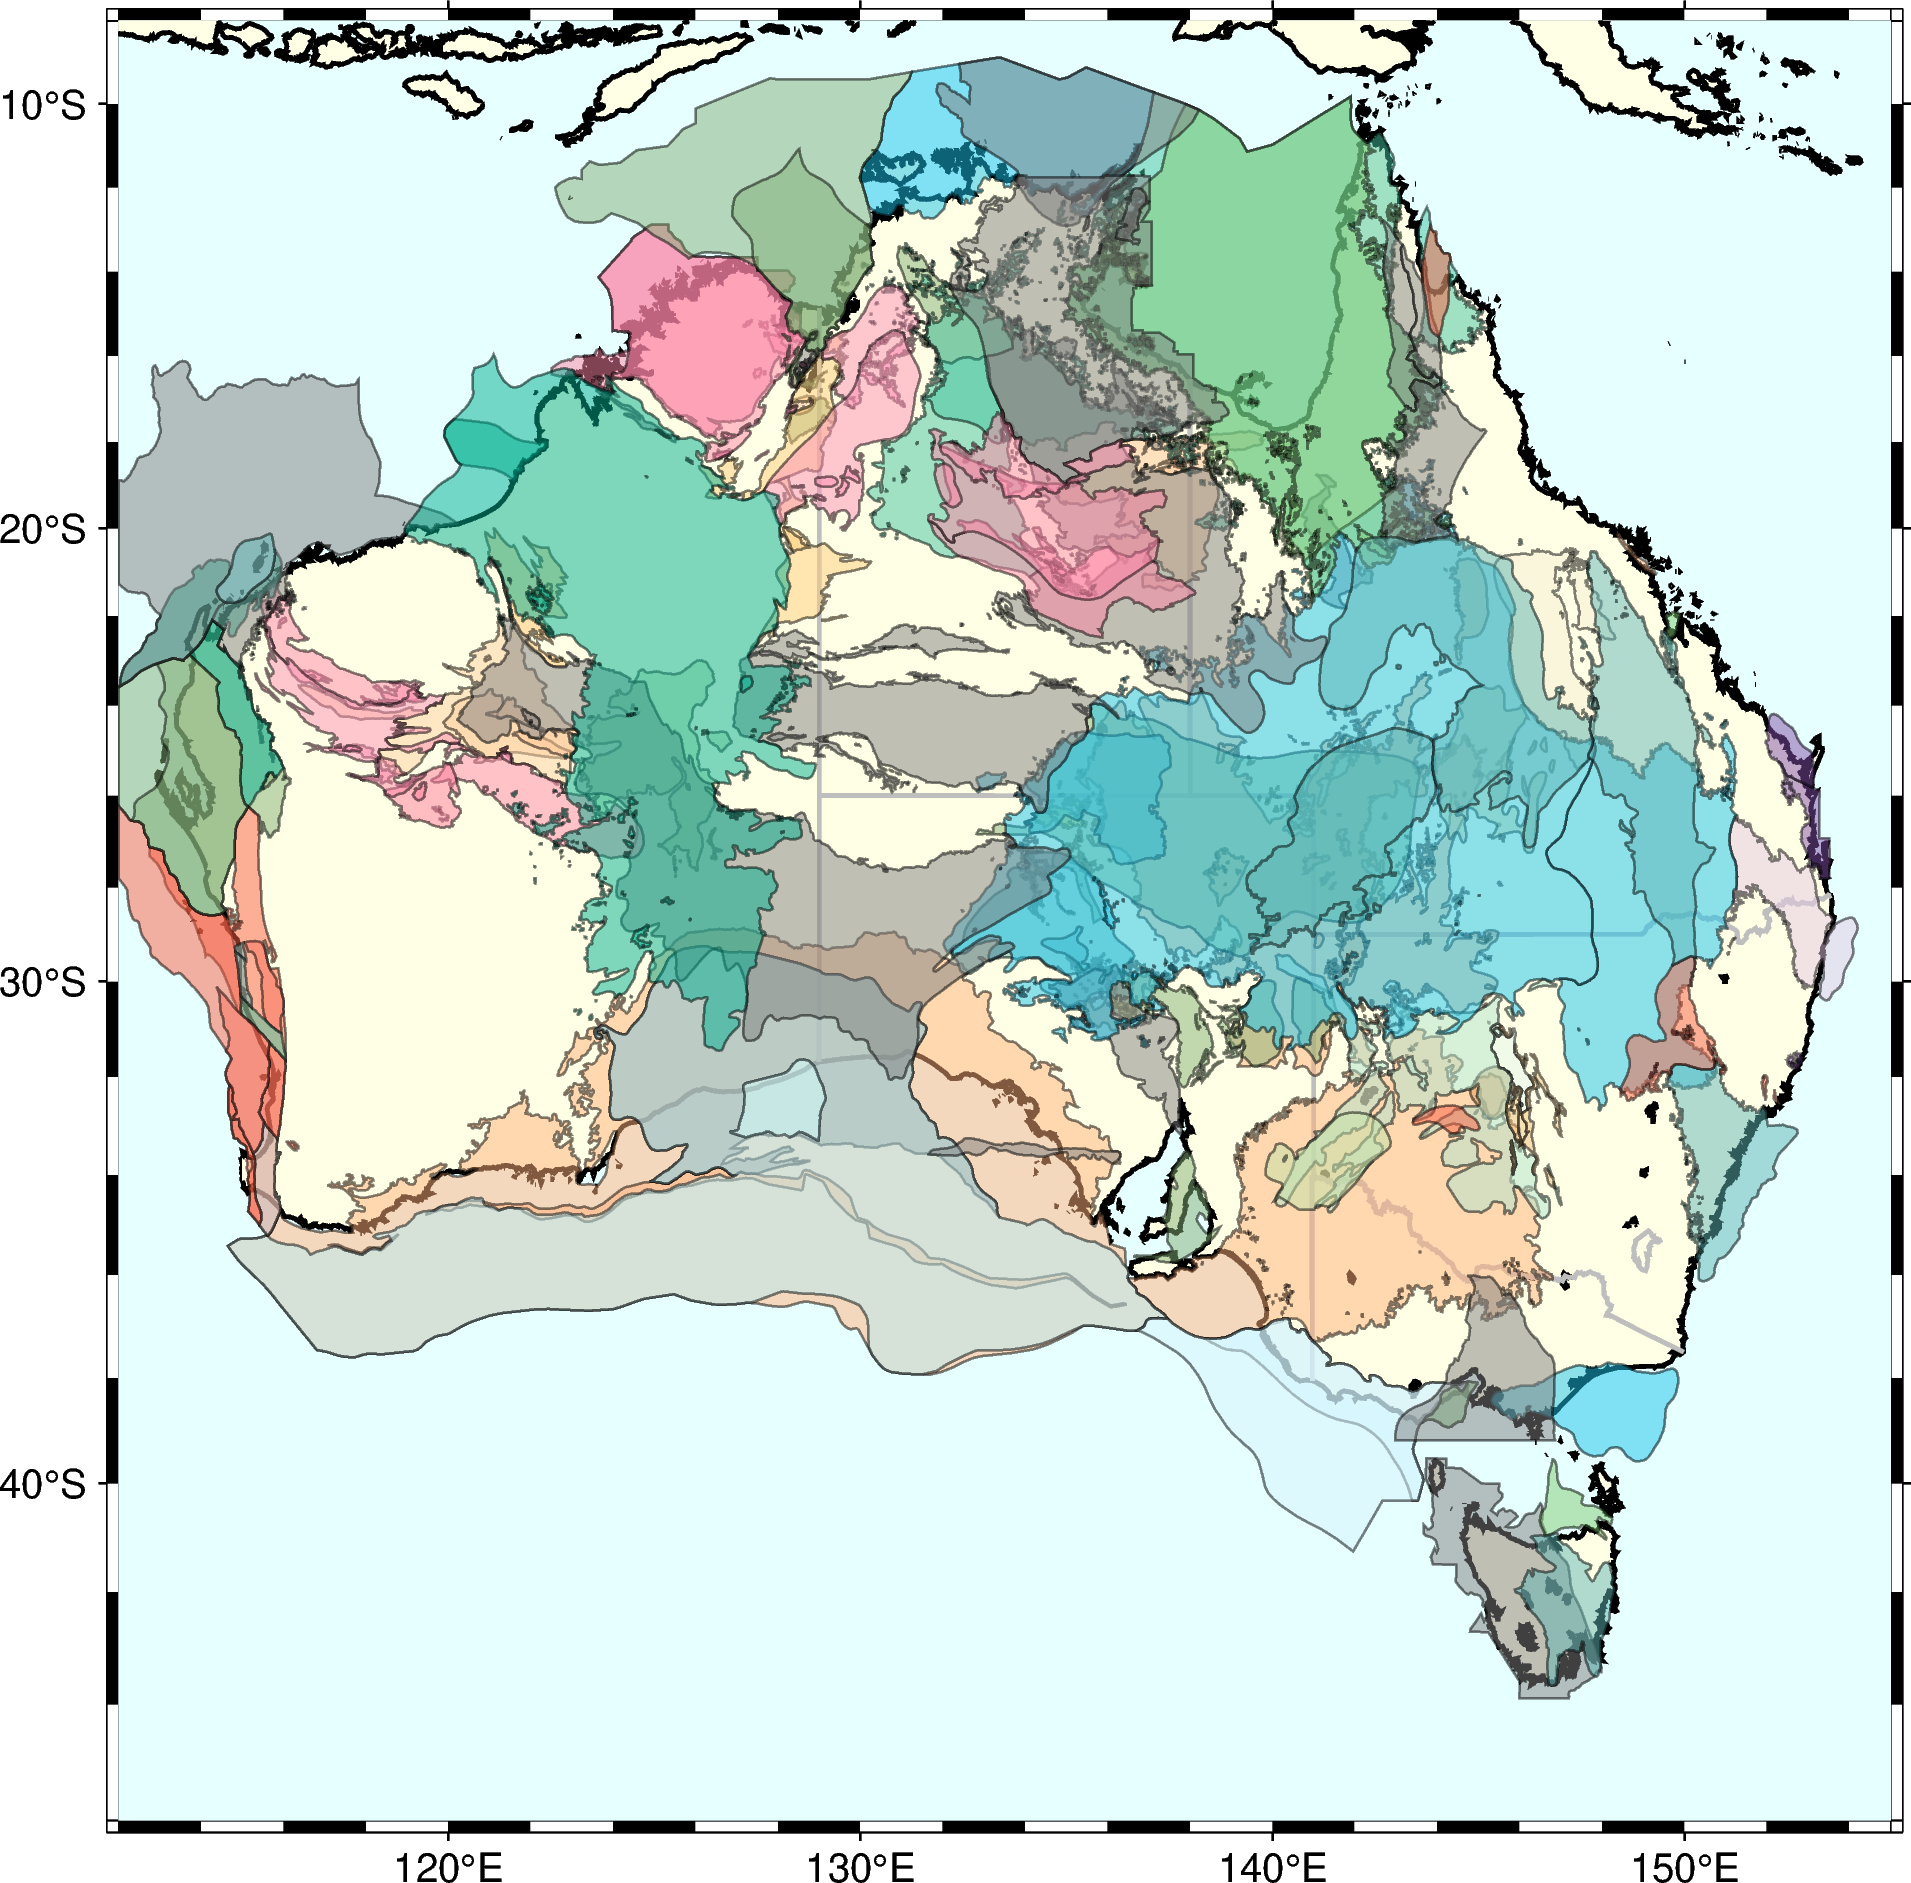

In [5]:
fig, region, projection = australia()
polygons = pd.read_csv("/Users/auggiemarignier/data/AUS_SED_BASINS/all.csv")
polygons["Shape"] = polygons["Shape"].map(lambda x: x.strip("MULTIPOLYGON"))
polygons.drop(polygons[polygons.onoffshore == "Off"].index, inplace=True)
for i, polygon in polygons.iterrows():
    shapes = re.findall('\([^)]*\)', polygon["Shape"])
    for shape in shapes:
        name = polygon["oldnameage"]
        if not isinstance(name, str):
            continue
        fill = "#80808080"
        for p in name.split():
            if p in geological_timeline:
                fill = geological_timeline[p]['fill']
                break
        shape = shape.strip("()").split(",")
        lonlat = pd.Series(shape).str.split(expand=True).astype(float)
        fig.plot(x=lonlat[0], y=lonlat[1], region=region, projection=projection, pen="0.5p,black", fill=fill, transparency=50)
fig.show()